In [75]:
import numpy as np
import pandas

# A executer pour que les widgets fonctionnent: "jupyter labextension install @jupyter-widgets/jupyterlab-manager" pour jupyterlab
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual

# Téléchargement des données de tests par département
data = pandas.read_csv("https://www.data.gouv.fr/fr/datasets/r/406c6a23-e283-4300-9484-54e78c8ae675",
               sep = ';', 
               dtype = {'dep':np.str, 'P':np.int32,'T':np.int32,'cl_age90':np.int32},
                parse_dates = ['jour']
               )

In [76]:
# Sélection du département
def g(dept):
    return dept
deptWidget = interactive(g, dept=data.dep.unique());
display(deptWidget)

interactive(children=(Dropdown(description='dept', options=('01', '02', '03', '04', '05', '06', '07', '08', '0…

In [83]:
dept = deptWidget.result
print("Affichage pour le département " + dept)
deptData = data.loc[data['dep'] == dept]

testedDeptAllAges = deptData.groupby(['jour'])['T'].sum()
positifDeptAllAges = deptData.groupby(['jour'])['P'].sum()


Affichage pour le département 55


In [84]:
from matplotlib import pyplot as plt
%matplotlib inline

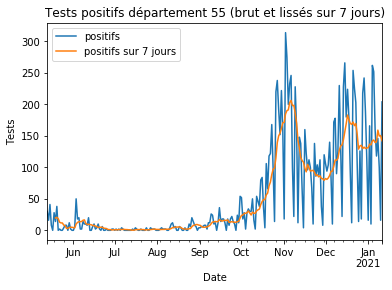

In [85]:
# Tests positifs
# Sélection de la période la plus récente (ex: 60 derniers jours)
positifDeptAllAges2 = positifDeptAllAges#[-60:-1]
# Graphique
positifDeptAllAges2.plot(x='jour', y='P', label='positifs')
# Moyennage sur 7 jours glissants pour lisser l'absence de tests le dimanche
positifDeptAllAges2.rolling(7).mean().plot(x='jour', label='positifs sur 7 jours')
# Légende
plt.legend()
plt.title("Tests positifs département " + dept + " (brut et lissés sur 7 jours)")
plt.xlabel("Date")
plt.ylabel("Tests")
plt.show()

In [6]:
# Afficher les chiffres bruts des 10 derniers jours
print(positifDeptAllAges2[-10:])

jour
2020-12-24     634
2020-12-25      81
2020-12-26     408
2020-12-27     104
2020-12-28    1052
2020-12-29     879
2020-12-30    1010
2020-12-31     810
2021-01-01      62
2021-01-02     528
Name: P, dtype: int32


In [7]:
# Date des dernières données (en général quelques jours en arrière, données consolidées)
print("Dernières données du " + str(data.jour.unique()[-1])[:10])

Dernières données du 2021-01-02


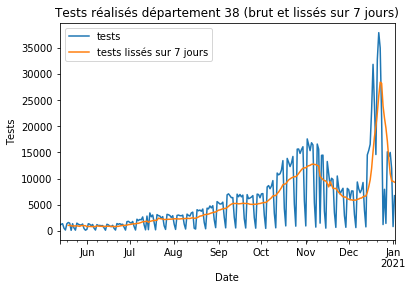

In [8]:
# Nombre de tests réalisés
testedDeptAllAges.plot(x='jour', y='T', label='tests')
testedDeptAllAges.rolling(7).mean().plot(x='jour', label='tests lissés sur 7 jours')
plt.legend()
plt.title("Tests réalisés département " + dept + " (brut et lissés sur 7 jours)")
plt.xlabel("Date")
plt.ylabel("Tests")
#data.plot(x='jour', y='T')#, ylabel='testés')
#data.plot(x='jour', y='P')#, ylabel='positifs')
plt.show()


In [9]:
# Code EPCI des métropoles - sélection d'une 'métropole
metros = pandas.read_csv("https://www.data.gouv.fr/fr/datasets/r/0fa52fca-4eb3-4786-92f1-6db24273068f",
               sep = ';', 
               encoding = "ISO-8859-15",
               dtype = {'EPCI':np.str, 'Metropole':np.str},
        )
metros = list(metros.itertuples(index=False, name=None))
metros2 = [m[::-1] for m in metros]

def f(metropole):
    return(metropole)

metroWidget = interactive(f, metropole=metros2);
display(metroWidget)

interactive(children=(Dropdown(description='metropole', options=(('Bordeaux', '243300316'), ('Brest', '2429003…

In [10]:
metroEPCI = metroWidget.result
print("Affichage des données pour la métropole de "+[metro[1] for metro in metros if metro[0] == metroEPCI][0])

Affichage des données pour la métropole de Grenoble


In [11]:
# Lecture des données COVID par métropole
dataMetros = pandas.read_csv("https://www.data.gouv.fr/fr/datasets/r/61533034-0f2f-4b16-9a6d-28ffabb33a02",
               sep = ';', 
               dtype = {'epci2020':np.str, 'ti':np.float64,'clage_65':np.int32, 'semaine_glissante':np.str},
                #parse_dates = ['semaine_glissante']
               )

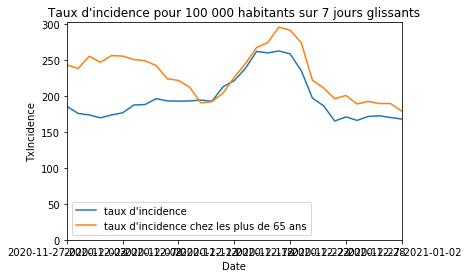

In [12]:
metropole = dataMetros[dataMetros.epci2020 == metroEPCI]
metropoleSorted = metropole.sort_values("semaine_glissante")
metropoleAll = metropoleSorted[metropoleSorted.clage_65 == 0]
#print(metropoleAll)
metropolePlus65 = metropoleSorted[metropoleSorted.clage_65 != 0]
#print(metropolePlus65)
ax = metropoleAll.plot(x='semaine_glissante', y='ti', label='taux d\'incidence')
metropolePlus65.plot(x='semaine_glissante', y='ti', label='taux d\'incidence chez les plus de 65 ans', ax=ax)

plt.legend()
plt.title("Taux d'incidence pour 100 000 habitants sur 7 jours glissants")
plt.xlabel("Date")
plt.ylabel("TxIncidence")
ax.set_ylim(bottom=0)
plt.show()

In [45]:
# Données par quartier : Code localisation 381850210	Ile Verte-Maréchal Randon, cf https://www.data.gouv.fr/fr/datasets/donnees-de-laboratoires-infra-departementales-durant-lepidemie-covid-19/
# Afficher une carte avec ipyleaflet
# Ajouter les contours IRIS sélectionnables https://geoservices.ign.fr/documentation/diffusion/telechargement-donnees-libres.html au format shapefile
# Récupérer les données (135 Mo à télécharger !)
# Afficher celles de la zone choisie
# https://www.data.gouv.fr/fr/datasets/r/44d4c265-24c3-4720-9144-f3e4a5213422 -> données par zone IRIS 
#
# Sélectionner une zone IRIS et cliquer pour voir le code à 9 chiffres: https://www.geoportail.gouv.fr/donnees/iris
# Ex: Île Verte-Maréchal Randon 381850210
dataIris = pandas.read_csv("https://www.data.gouv.fr/fr/datasets/r/44d4c265-24c3-4720-9144-f3e4a5213422",
               delimiter="[\[\]]?;[\]\[]?", skiprows=1, names=["iris2019", "semaine_glissante", "clage_65", "ti_classe_min", "ti_classe_max", "td_classe_min", "td_classe_max", "tp_classe_min", "tp_classe_max"])

/home/manik/.local/lib/python3.5/site-packages/ipykernel_launcher.py:9: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  if __name__ == '__main__':


In [59]:
ileVerte = dataIris[dataIris.iris2019 == '381850210']
ileVerteSorted = ileVerte.sort_values("semaine_glissante")
ileVerteAll = ileVerteSorted[ileVerteSorted.clage_65 == 0]
ileVerteAll.ti_classe_min = pandas.to_numeric(ileVerteAll['ti_classe_min'], errors='coerce')
ileVerteAll.ti_classe_max = pandas.to_numeric(ileVerteAll['ti_classe_max'], errors='coerce')
ileVerteAll.td_classe_min = pandas.to_numeric(ileVerteAll['td_classe_min'], errors='coerce')
ileVerteAll.td_classe_max = pandas.to_numeric(ileVerteAll['td_classe_max'], errors='coerce')
ileVerteAll.tp_classe_min = pandas.to_numeric(ileVerteAll['tp_classe_min'], errors='coerce')
ileVerteAll.tp_classe_max = pandas.to_numeric(ileVerteAll['tp_classe_max'], errors='coerce')

/usr/local/lib/python3.5/dist-packages/pandas/core/generic.py:5096: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


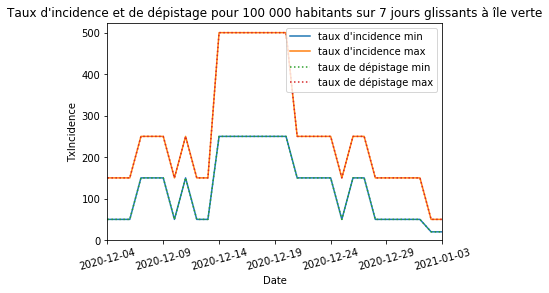

In [68]:
ax = ileVerteAll.plot(x='semaine_glissante', y='ti_classe_min', label='taux d\'incidence min')
ileVerteAll.plot(x='semaine_glissante', y='ti_classe_max', label='taux d\'incidence max',ax=ax)

ileVerteAll.plot(x='semaine_glissante', y='ti_classe_min', label='taux de dépistage min', linestyle=':', ax=ax)
ileVerteAll.plot(x='semaine_glissante', y='ti_classe_max', label='taux de dépistage max', linestyle=':', ax=ax)

plt.legend()
plt.title("Taux d'incidence et de dépistage pour 100 000 habitants sur 7 jours glissants à île verte")
plt.xlabel("Date")
labels = [item.get_text()[11:] for item in ax.get_xticklabels()]
ax.set_xticklabels(labels)
plt.ylabel("TxIncidence")
ax.set_ylim(bottom=0)
plt.xticks(rotation = 15)
plt.show()

In [72]:
print(ileVerteAll[['semaine_glissante','ti_classe_min', 'ti_classe_max']])

            semaine_glissante  ti_classe_min  ti_classe_max
376223  2020-11-28-2020-12-04           50.0            150
376625  2020-11-29-2020-12-05           50.0            150
377027  2020-11-30-2020-12-06           50.0            150
377429  2020-12-01-2020-12-07          150.0            250
377831  2020-12-02-2020-12-08          150.0            250
378233  2020-12-03-2020-12-09          150.0            250
378635  2020-12-04-2020-12-10           50.0            150
379037  2020-12-05-2020-12-11          150.0            250
379439  2020-12-06-2020-12-12           50.0            150
379841  2020-12-07-2020-12-13           50.0            150
380243  2020-12-08-2020-12-14          250.0            500
380645  2020-12-09-2020-12-15          250.0            500
381047  2020-12-10-2020-12-16          250.0            500
381449  2020-12-11-2020-12-17          250.0            500
381851  2020-12-12-2020-12-18          250.0            500
382253  2020-12-13-2020-12-19          2